# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : CamemBERT

---

# Environnement
---

In [1]:
cd ../..

/Volumes/Geek/Work/Patat


In [2]:
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

## Données

In [37]:
filename = 'data/tmp/french_tweets.csv'
df_tweets = pd.read_csv(filename).sample(5000).reset_index(drop=True)
df_tweets

,label,text
0,0,Vendredi soir est la nuit de ma fête de la sem...
1,0,Chiffres. Un jour de congé demain et la prévis...
2,0,Alecyberspace quelque chose doit être fait !!
3,1,Je pense que nous devrions faire du spaghetti Sme
4,0,Sera un forum publicitaire de masse aujourd'hu...
...,...,...
4995,0,À la maison du travail ... woot! Bat la nuit d...
4996,1,Comment allez-vous faire cela?
4997,1,La musique sonne f-i-t cette veille ensoleillé...
4998,1,: 20somethin 'single


## GPU Check

In [38]:
import torch

torch_device='cpu'

if torch.backends.mps.is_available():
    torch_device='mps'
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

print(f'torch_device = {torch_device} ')

tensor([1.], device='mps:0')
torch_device = mps 


# Python modules

In [39]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange, tqdm
import random

# Tokenization

## CamemBERT tokenizer

In [40]:
bert_tokenizer = AutoTokenizer.from_pretrained("camembert-base")

In [41]:
text = df_tweets.sample(1)['text'].iloc[0]

In [42]:
len(bert_tokenizer.tokenize(text))

39

In [43]:
df_tweets['bert_tokens']=df_tweets['text'].progress_apply(bert_tokenizer.tokenize)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [44]:
df_tweets['bert_tokens']

0       [▁Vendredi, ▁soir, ▁est, ▁la, ▁nuit, ▁de, ▁ma,...
1       [▁Chiffre, s, ., ▁Un, ▁jour, ▁de, ▁congé, ▁dem...
2       [▁A, le, cy, ber, space, ▁quelque, ▁chose, ▁do...
3       [▁Je, ▁pense, ▁que, ▁nous, ▁devrions, ▁faire, ...
4       [▁Ser, a, ▁un, ▁forum, ▁publicitaire, ▁de, ▁ma...
                              ...                        
4995    [▁À, ▁la, ▁maison, ▁du, ▁travail, ▁..., ▁wo, o...
4996        [▁Comment, ▁allez, -, vous, ▁faire, ▁cela, ?]
4997    [▁La, ▁musique, ▁sonne, ▁f, -, i, -, t, ▁cette...
4998          [▁:, ▁20, s, ome, th, in, ▁, ', s, ing, le]
4999    [▁J, ', espère, !, ▁Mon, ▁si, s, ▁arrive, ▁à, ...
Name: bert_tokens, Length: 5000, dtype: object

In [45]:
df_tweets['btokens_count'] = df_tweets['bert_tokens'].apply(len)

In [46]:
df_tweets.shape

(5000, 4)

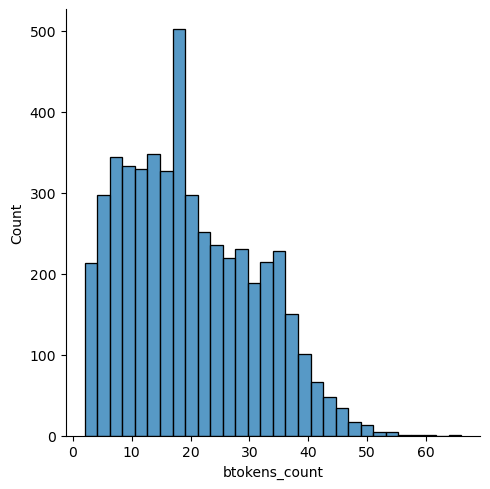

In [47]:
sns.displot(df_tweets,x='btokens_count',bins=30)

In [48]:
text = df_tweets.sample(1)['text'].iloc[0]

In [49]:
table = np.array([bert_tokenizer.tokenize(text), 
                bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(text))]).T
print(tabulate(table,
         headers = ['Tokens', 'Token IDs'],
         tablefmt = 'fancy_grid'))

╒═══════════╤═════════════╕
│ Tokens    │   Token IDs │
╞═══════════╪═════════════╡
│ ▁Oh       │        4684 │
├───────────┼─────────────┤
│ ▁internet │         890 │
├───────────┼─────────────┤
│ ▁où       │         147 │
├───────────┼─────────────┤
│ ▁es       │        1252 │
├───────────┼─────────────┤
│ -         │          26 │
├───────────┼─────────────┤
│ tu        │         744 │
├───────────┼─────────────┤
│ ▁toute    │         194 │
├───────────┼─────────────┤
│ ▁ma       │         155 │
├───────────┼─────────────┤
│ ▁vie      │         157 │
╘═══════════╧═════════════╛


In [28]:
texts = df_tweets['text']
labels = df_tweets['label']

In [50]:
tokenizer = bert_tokenizer
def print_rand_sentence():
    '''Displays the tokens and respective IDs of a random text sample'''
    index = random.randint(0, len(texts)-1)
    table = np.array([tokenizer.tokenize(texts[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[index]))]).T
    print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒═══════════╤═════════════╕
│ Tokens    │   Token IDs │
╞═══════════╪═════════════╡
│ ▁Om       │       14236 │
├───────────┼─────────────┤
│ g         │         383 │
├───────────┼─────────────┤
│ ▁les      │          19 │
├───────────┼─────────────┤
│ ▁collines │       15680 │
├───────────┼─────────────┤
│ !         │         152 │
├───────────┼─────────────┤
│ ▁Alors    │         574 │
├───────────┼─────────────┤
│ ▁j        │          76 │
├───────────┼─────────────┤
│ '         │          11 │
├───────────┼─────────────┤
│ aime      │         660 │
├───────────┼─────────────┤
│ ▁l        │          17 │
├───────────┼─────────────┤
│ '         │          11 │
├───────────┼─────────────┤
│ argent    │        1042 │
├───────────┼─────────────┤
│ 2,        │        3502 │
├───────────┼─────────────┤
│ ▁a        │          33 │
├───────────┼─────────────┤
│ w         │         640 │
├───────────┼─────────────┤
│ w         │         640 │
├───────────┼─────────────┤
│ ▁je       │       

# Sentence Encoding / Embeding

In [51]:

token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
    '''
    Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
    '''
    return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

for sample in texts:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/homebrew/Caskroom/miniforge/base/envs/gpu39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/var/folders/fr/mhrqmk5n1xs49b7jl3tgs2r00000gn/T/ipykernel_284

In [52]:
def print_rand_sentence_encoding():
    '''Displays tokens, token IDs and attention mask of a random text sample'''
    index = random.randint(0, len(texts) - 1)
    tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
    token_ids = [i.numpy() for i in token_id[index]]
    attention = [i.numpy() for i in attention_masks[index]]

    table = np.array([tokens, token_ids, attention]).T
    print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒═════════════╤═════════════╤══════════════════╕
│ Tokens      │   Token IDs │   Attention Mask │
╞═════════════╪═════════════╪══════════════════╡
│ <s>         │           5 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ▁J          │         121 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ '           │          11 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ai          │          73 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ▁plongé     │       14950 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ▁plusieurs  │         247 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ▁fois       │         151 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ▁pour       │          24 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ▁la         │          13 │                1 │
├─────────────┼─────

# Train / Test Split

In [53]:
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

# Metrics

In [55]:
def b_tp(preds, labels):
    '''Returns True Positives (TP): count of correct predictions of actual class 1'''
    return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
    '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
    return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
    '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
    return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
    '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
    return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
    '''
    Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
    '''
    preds = np.argmax(preds, axis = 1).flatten()
    labels = labels.flatten()
    tp = b_tp(preds, labels)
    tn = b_tn(preds, labels)
    fp = b_fp(preds, labels)
    fn = b_fn(preds, labels)
    b_accuracy = (tp + tn) / len(labels)
    b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
    b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
    b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
    return b_accuracy, b_precision, b_recall, b_specificity

# Training

In [56]:
from transformers import AutoModelForSequenceClassification


# Load the BertForSequenceClassification model
model = AutoModelForSequenceClassification.from_pretrained(
    'camembert-base',
    num_labels = 1,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

# Run on GPU
#model.cuda()
#model.to('cpu')
model.to(torch_device)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [59]:
#%%time
#device=torch.device('cpu')
device=torch.device(torch_device)
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2
for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        
        batch = tuple(t.to(torch.float32).to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids.to(torch.int), 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(torch.float32).to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids.to(torch.int), 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  50%|███████████████████████████████████████████                                           | 1/2 [00:07<00:07,  7.81s/it]


	 - Train loss: 0.0013
	 - Validation Accuracy: 1.0000
	 - Validation Precision: NaN
	 - Validation Recall: NaN
	 - Validation Specificity: 1.0000



Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.49s/it]


	 - Train loss: 0.0004
	 - Validation Accuracy: 1.0000
	 - Validation Precision: NaN
	 - Validation Recall: NaN
	 - Validation Specificity: 1.0000



# Make Predictions

In [95]:
new_sentence = 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'

In [96]:
new_sentence = 'Please update your account data at https://dsfsdsq.ru/sd'

In [98]:
# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Infox' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Non Infox'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  Please update your account data at https://dsfsdsq.ru/sd
Predicted Class:  Non Infox


# Data

In [ ]:
#!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'

In [ ]:
#!unzip -o smsspamcollection.zip

In [ ]:
cd ../..

In [ ]:
import patat.util.pd

In [ ]:
filename = 'data/prod/230512-OIDS-Label.csv'
df_label = patat.util.pd.df_from_csvjson(['tags','paragraphs'],filename)

In [ ]:
df_label = df_label.sample(frac=1)

In [ ]:
texts = df_label['title'].values
labels = df_label['infox'].values

In [ ]:
texts[:10]

In [ ]:
labels[:10]

# Install

In [ ]:
!conda install transformers -y

In [ ]:
!conda install scikit-learn -y

In [ ]:
!conda install tabulate -y